# MUSIC for Direction of Arrival

This notebook is a demo of MUSIC for Direction of Arrival

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.signal import find_peaks
from scipy.signal import hilbert
from scipy.signal import peak_widths

import pandas as pd
import seaborn as sns

import sys
sys.path.append("src")

from music import *
from music_advanced import *
from simulated_signal import *

In [2]:
# Constants
thetas = np.array([0.5, 1]) # in radians (should be in [0, pi/2])
n_sources = len(thetas)
w0 = np.pi / 5
n_mics = 24
mic_distance = 1
noise_var = 2
fs = 2000

aligned_mics_coords = np.array([(0, mic_distance * i) for i in range(n_mics)]).T
main_frequency = (fs * w0) / (2 * np.pi)
wavelength = SOUND_SPEED / main_frequency

# Plot for multiple noise variances

We have $SNR=10\log_{10}\frac{\sigma_s^2}{\sigma_n^2}$ where $\sigma_s^2$ is the variance of the signal and $\sigma_n^2$ is the variance of the noise. So $\sigma_n^2=\frac{\sigma_s^2}{10^{\frac{SNR}{10}}}$.

In [3]:
def get_noise_var(snr, signal_var):
    temp = 10 ** (snr/10)
    return signal_var / temp

In [4]:
def get_samples(mic_distance, thetas, wavelength, n_mics, n_sources, n_samples, snr):
    phis = np.array([np.exp(-2j * np.pi * mic_distance * np.sin(theta) / wavelength) for theta in thetas])
    A = np.vander(phis, n_mics, increasing=True).T
    S = np.random.normal(0, 1, (n_sources, n_samples))
    
    signal_var = np.var(S, axis=1).mean()
    
    noise_matrix = np.random.normal(0, get_noise_var(snr, signal_var), (n_mics, n_samples, 2)).view(np.complex128)\
                                        .reshape((n_mics, n_samples))

    return (A @ S) + noise_matrix

In [5]:
n_samples = 100
snr_values = [10, 0, -5]
samples_diff_var = []

for snr in snr_values:
    samples = get_samples(mic_distance, thetas, wavelength, n_mics, n_sources, n_samples, snr=snr)
    samples_diff_var.append(samples)

Samples shape: (24, 100)
Covariance shape: (24, 24)
Samples shape: (24, 100)
Covariance shape: (24, 24)
Samples shape: (24, 100)
Covariance shape: (24, 24)


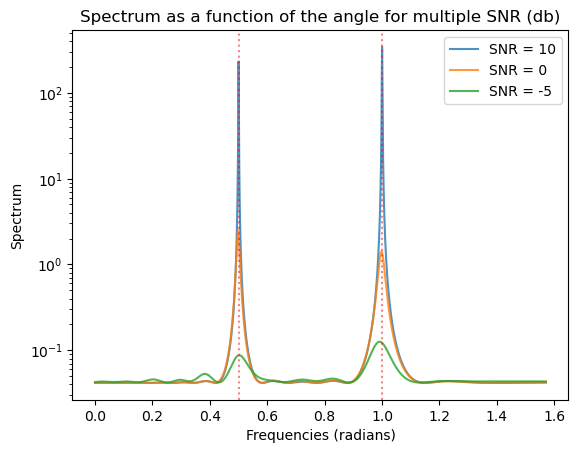

In [6]:
spectrums = [music(sampled_received, n_sources, aligned_mics_coords, main_frequency)
             for sampled_received in samples_diff_var]

X = np.linspace(0, np.pi/2, 10000)
Y = [[spectrum(x) for x in X] for spectrum in spectrums]

for i, y in enumerate(Y):
    plt.plot(X, y, label=f'SNR = {snr_values[i]}', alpha=0.8)
plt.legend()
plt.xlabel('Frequencies (radians)')
plt.ylabel('Spectrum')
plt.yscale('log')
plt.title('Spectrum as a function of the angle for multiple SNR (db)')
for theta in thetas:
    plt.axvline(x=theta, color='red', linestyle=':', alpha=0.5)
plt.show()

For SNR = 10, the MSE is 3.47E-05
For SNR = 0, the MSE is 2.71E-03
For SNR = -5, the MSE is 8.98E-03


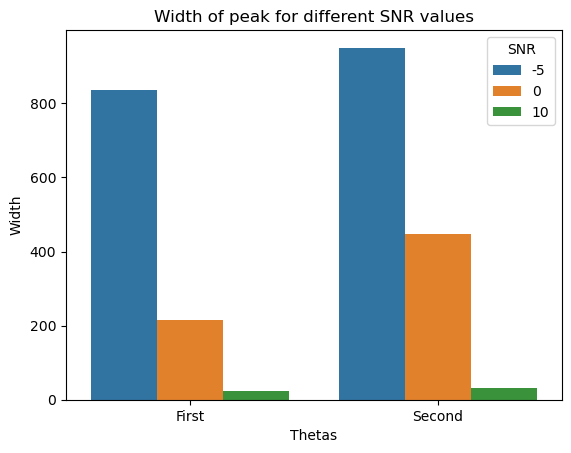

In [7]:
df = pd.DataFrame(columns = ['Width', 'Thetas', 'SNR'])

color = ['blue', 'red', 'green']
for i, spectrum in enumerate(spectrums):
    estimated_thetas, indices = extract_frequencies(spectrum, n_sources, [0, np.pi / 2], return_peak_indices=True)
    print(f'For SNR = {snr_values[i]}, the MSE is {np.sqrt(np.sum((sorted(estimated_thetas)-thetas)**2)):.2E}')

    width, height, start, end = peak_widths(Y[i], indices, rel_height=0.9)
    sorted_indices = np.argsort(start)
    width = width[sorted_indices]
    df.loc[len(df)] = [width[0], 'First', snr_values[i]]
    df.loc[len(df)] = [width[1], 'Second', snr_values[i]]

sns.barplot(df, x="Thetas", y="Width", hue="SNR")
plt.title('Width of peak for different SNR values')
plt.show()

# Plot for narrowband benchmark

In [37]:
narrowband_signals = [narrowband_signal(k, w0) for k in range(n_sources)]
received_signals = [received_signal(thetas, narrowband_signals, 
                                    mic_index=m+1, 
                                    main_frequency=main_frequency,
                                    mic_distance=mic_distance, 
                                    noise_var=0) for m in range(n_mics)]

n_samples = 1000

sampled_received = np.zeros((len(received_signals), n_samples), dtype=np.csingle)

for i, received in enumerate(received_signals):
    for j in range(n_samples):
        sampled_received[i, j] = received(j / fs)

sampled_received.shape

(24, 1000)

Samples shape: (24, 1000)
Covariance shape: (24, 24)
Shape of sources STFT: (500, 3, 24)
STFD shape: (24, 24)
Shape of noise eigenvectors: (24, 22)


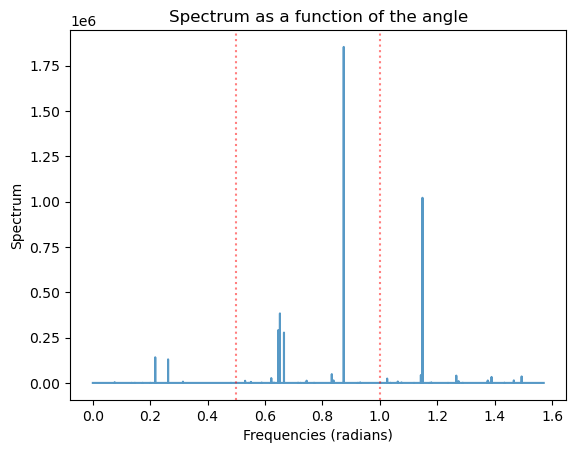

In [43]:
coordinates = np.zeros((2, n_mics))
for i in range(coordinates.shape[1]):
    coordinates[1, i] = i * mic_distance
length = 20


spectrum = music(sampled_received, n_sources, coordinates, main_frequency)
spectrum_stft = music_with_frequency(sampled_received, n_sources, fs, coordinates, segment_duration=0.5,
                                     freq_range=None)#[main_frequency-length, main_frequency+length]

X = np.linspace(0, np.pi/2, 10000)
Y = [spectrum_stft(x) for x in X]

plt.plot(X, Y, alpha=0.75)
plt.xlabel('Frequencies (radians)')
plt.ylabel('Spectrum')
#plt.yscale('log')
plt.title('Spectrum as a function of the angle')
for theta in thetas:
    plt.axvline(x=theta, color='red', linestyle=':', alpha=0.5)
plt.show()

In [45]:
coordinates

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.]])

In [10]:
'''phis = np.array([np.exp(-2j * np.pi * mic_distance * np.sin(theta) / wavelength) for theta in thetas])
A = np.vander(phis, n_mics, increasing=True).T
S = np.random.normal(0, 1, (n_sources, n_samples))
noise_matrix = np.random.normal(0, noise_var, (n_mics, n_samples, 2)).view(np.complex128)\
                                    .reshape((n_mics, n_samples))

sampled_received = (A @ S) + noise_matrix'''

'phis = np.array([np.exp(-2j * np.pi * mic_distance * np.sin(theta) / wavelength) for theta in thetas])\nA = np.vander(phis, n_mics, increasing=True).T\nS = np.random.normal(0, 1, (n_sources, n_samples))\nnoise_matrix = np.random.normal(0, noise_var, (n_mics, n_samples, 2)).view(np.complex128)                                    .reshape((n_mics, n_samples))\n\nsampled_received = (A @ S) + noise_matrix'

# Plot for broadband benchmark + runtime

# Plot for correlated sources

In [11]:
def get_samples_correlated_sources(mic_coords, thetas, wavelength, n_mics, n_sources, n_samples, noise_var):
    A = np.zeros((n_mics, n_sources), dtype = 'complex_')
    
    for m in range(n_mics):
        for k in range(n_sources):
            d = mic_coords[0, m]*np.cos(thetas[k])+mic_coords[1, m]*np.sin(thetas[k])
            A[m, k] = np.exp(-1j*2*np.pi/wavelength*d)
    
    S = np.zeros((n_sources, n_samples))
    
    # Weakly correlated
    S[0] = np.random.normal(0, 1, (1, n_samples))
    S[1] = 1/np.sqrt(2)*S[0]+1/np.sqrt(2)*np.random.normal(0, 1, (1, n_samples))
    S[2] = 1/np.sqrt(2)*S[1]+1/np.sqrt(2)*np.random.normal(0, 1, (1, n_samples))
    S[3] = 1/np.sqrt(2)*S[2]+1/np.sqrt(2)*np.random.normal(0, 1, (1, n_samples))
    
    #S[0] = np.random.normal(0, 1, (1, n_samples))
    #S[2] = np.random.normal(0, 1, (1, n_samples))
    #S[1] = 0.1*S[0]+2*S[2]
    #S[3] = np.random.normal(0, 1, (1, n_samples))
    
    noise_matrix = np.random.normal(0, noise_var, (n_mics, n_samples, 2)).view(np.complex128)\
                                        .reshape((n_mics, n_samples))
    return (A @ S) + noise_matrix

def get_samples_not_aligned(mic_coords, thetas, wavelength, n_mics, n_sources, n_samples, noise_var):
    A = np.zeros((n_mics, n_sources), dtype = 'complex_')
    
    for m in range(n_mics):
        for k in range(n_sources):
            d = mic_coords[0, m]*np.cos(thetas[k])+mic_coords[1, m]*np.sin(thetas[k])
            A[m, k] = np.exp(-1j*2*np.pi/wavelength*d)
            
    S = np.random.normal(0, 1, (n_sources, n_samples))
    
    noise_matrix = np.random.normal(0, noise_var, (n_mics, n_samples, 2)).view(np.complex128)\
                                        .reshape((n_mics, n_samples))

    return (A @ S) + noise_matrix

In [12]:
coordinates = np.zeros((2, n_mics))
for i in range(coordinates.shape[1]):
    coordinates[1, i] = i * mic_distance

    
import json   
with open('../music_doa/last_year/protocol.json') as json_file:  
    protocol = json.load(json_file)
    
microphone_3D_locations = np.array(protocol['geometry']['microphones']['locations'])
top_mics = np.isclose(microphone_3D_locations[:,2], 0.06123724)
microphone_2D_locations = microphone_3D_locations[top_mics, :2]
room_dim = np.r_[10.,10.]
coordinates = (microphone_2D_locations + room_dim / 2).T

In [13]:
thetas = [0.2, 0.5, 1, 1.4]
n_sources = len(thetas)
corr = get_samples_correlated_sources(coordinates, thetas, wavelength, n_mics, n_sources, n_samples, noise_var=1)
indep = get_samples_not_aligned(coordinates, thetas, wavelength, n_mics, n_sources, n_samples, noise_var=1)
names = ['correlated sources', 'independent sources', 'correlated music']

Samples shape: (24, 100)
Covariance shape: (24, 24)
Samples shape: (24, 100)
Covariance shape: (24, 24)
Samples shape: (24, 100)
Covariance shape: (24, 24)


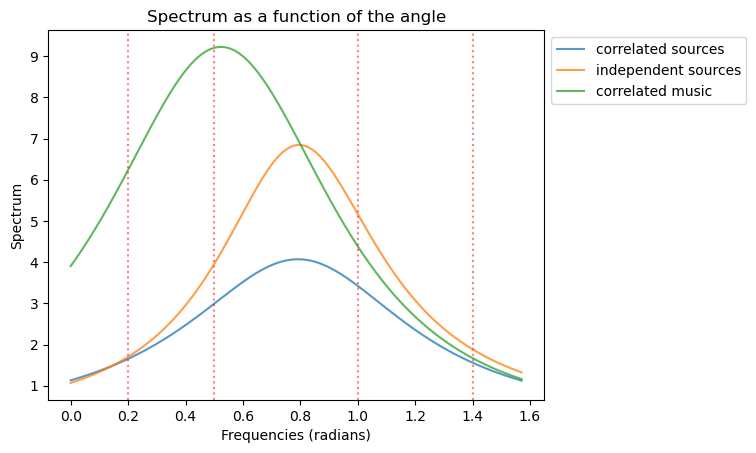

In [14]:
spectrums = [music(sampled_received, n_sources, coordinates, main_frequency) for sampled_received in [corr, indep]]
spectrums.append(music(corr, n_sources, coordinates, main_frequency, correlated=True))

X = np.linspace(0, np.pi/2, 10000)
Y = [[spectrum(x) for x in X] for spectrum in spectrums]

for i, y in enumerate(Y):
    plt.plot(X, y, label=names[i], alpha=0.75)
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('Frequencies (radians)')
plt.ylabel('Spectrum')
#plt.yscale('log')
plt.title('Spectrum as a function of the angle')
for theta in thetas:
    plt.axvline(x=theta, color='red', linestyle=':', alpha=0.5)
plt.show()

In [15]:
for spectrum in spectrums:
    estimated_thetas = extract_frequencies(spectrum, n_sources, [0, np.pi / 2])
    print('estimated thetas:',sorted(estimated_thetas), 'for number of sources =', n_sources)
print('actual thetas:   ', thetas)

estimated thetas: [0.7915242690719484] for number of sources = 4
estimated thetas: [0.7957654191542947] for number of sources = 4
estimated thetas: [0.523546415720739] for number of sources = 4
actual thetas:    [0.2, 0.5, 1, 1.4]


## Real data

Now, instead of crafting a signal, let's use pyroom acoustics and existing `.wav` files. We build on last year's project for the positions of the microphones.

In [16]:
import pyroomacoustics as pra
from scipy.io import wavfile
import IPython

import scipy
import json

In [17]:
fs, data = wavfile.read('res/arctic_a0010.wav')
data_variance = np.var(data)
IPython.display.Audio(data, rate=fs)

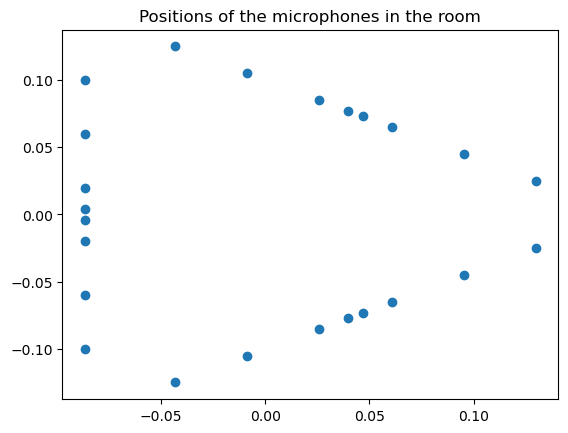

In [18]:
with open('../music_doa/last_year/protocol.json') as json_file:  
    protocol = json.load(json_file)
    
microphone_3D_locations = np.array(protocol['geometry']['microphones']['locations'])
top_mics = np.isclose(microphone_3D_locations[:,2], 0.06123724)
microphone_2D_locations = microphone_3D_locations[top_mics, :2]

plt.scatter(microphone_2D_locations[:, 0], microphone_2D_locations[:, 1])
plt.title("Positions of the microphones in the room")
plt.show()

In [19]:
# More constants
sigma2 = 0.1 * data_variance
distance = 3.  # meters

We now create the room using pyroom acoustics and add the microphone array as well as a source.

(<Figure size 640x480 with 1 Axes>, <Axes: >)

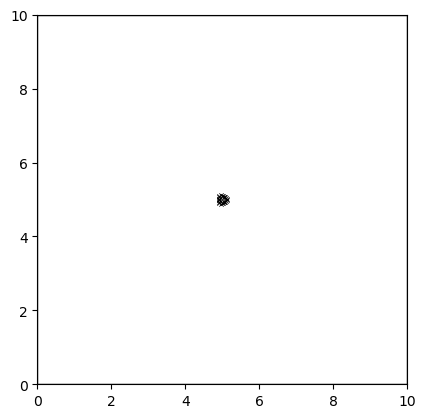

In [20]:
room_dim = np.r_[10.,10.]
aroom = pra.ShoeBox(room_dim, fs=fs, max_order=0, sigma2_awgn=sigma2)

# Adding the microphones

mics_coords = (microphone_2D_locations + room_dim / 2).T
aroom.add_microphone_array(pra.MicrophoneArray(mics_coords, aroom.fs))

aroom.plot()

(<Figure size 640x480 with 1 Axes>, <Axes: >)

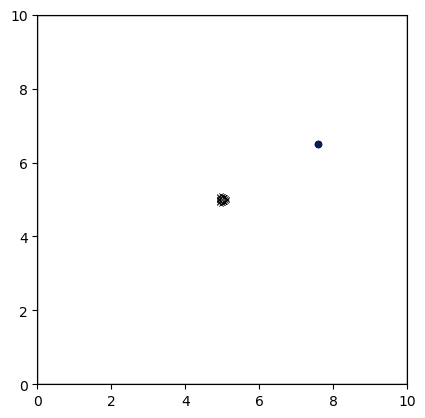

In [21]:
# Add sources of 1 second duration
azimuth = np.array([30]) / 180. * np.pi

rng = np.random.RandomState(23)
duration_samples = 10000

for ang in azimuth:
    random_phase = np.random.uniform(0, 2 * np.pi)
    source_location = room_dim / 2 + distance * np.r_[np.cos(ang), np.sin(ang)]
    aroom.add_source(source_location, signal=data)
    
# Run the simulation
aroom.simulate()
aroom.plot()

This is what the first microphone picked up.

In [22]:
IPython.display.Audio(aroom.mic_array.signals[0], rate=fs)

Now let's have a look at the FFT of the original audio file. The goal is to get the main frequency range of our signal for the STFT version of music (stay tuned!)

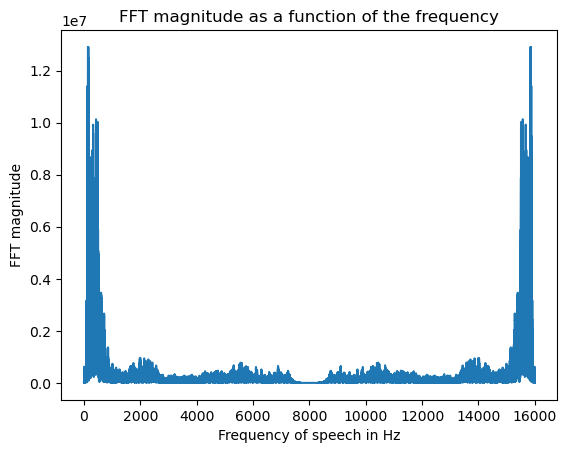

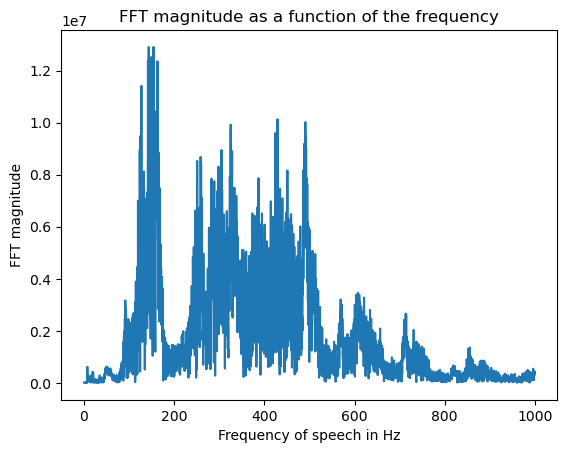

In [23]:
fft = np.fft.fft(data)
frequencies = np.linspace(0, fs, len(fft))

plt.plot(frequencies, abs(fft))
plt.xlabel("Frequency of speech in Hz")
plt.ylabel("FFT magnitude")
plt.title('FFT magnitude as a function of the frequency')
plt.show()

selected_ids = np.argwhere(frequencies < 1000)
selected_freq = frequencies[selected_ids]
selected_fft = fft[selected_ids]

plt.plot(selected_freq, abs(selected_fft))
plt.xlabel("Frequency of speech in Hz")
plt.ylabel("FFT magnitude")
plt.title('FFT magnitude as a function of the frequency')
plt.show()

We observe that our signal (without the noise) only spans a very small subset of frequencies. Thus, with the STFT version of MUSIC allows us to only focus on the relevant frequencies of our signal and get rid of a part of the noise that spans the whole frequency range.

The frequency range of interest is approximately [0, 500] Hz (this will be useful for the STFT version of MUSIC). 
On the other hand however, because of the narrowband assumption of standard MUSIC, we can only focus on a single frequency :(

Let's take the biggest spike which is roughly at 150 Hz

In [24]:
pra_main_frequency = 150
pra_freq_range = [0, 500]

Samples shape: (24, 57266)
Covariance shape: (24, 24)


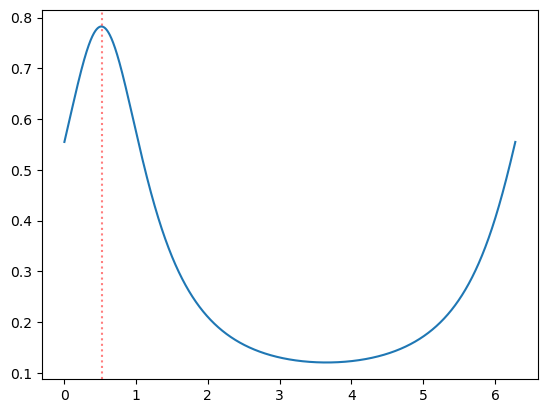

In [25]:
n_sources = len(azimuth)

spectrum = music(hilbert(aroom.mic_array.signals).conj(), n_sources, mics_coords, pra_main_frequency)

X = np.linspace(0, 2 * np.pi, 10000)
Y = [spectrum(x) for x in X]

plt.plot(X, Y)
for theta in azimuth:
    plt.axvline(x=theta, color='red', linestyle=':', alpha=0.5)
plt.show()

In [26]:
estimated_thetas = extract_frequencies(spectrum, 1, [0, np.pi / 2])
print(f'estimated angle in radians = {estimated_thetas[0]:.4f}, and in degrees = {estimated_thetas[0]/np.pi*180}')
print(f'true      angle in radians = {azimuth[0]:.4f}, and in degrees = {azimuth[0]/np.pi*180}')

estimated angle in radians = 0.5155, and in degrees = 29.538
true      angle in radians = 0.5236, and in degrees = 30.0


When we apply MUSIC for DOA to the received data, this is what we get. The angle is exactly at the first peak, but the spectrum is not very precise, it looks more like a sinusoid than a single spike. 

Furthermore, we notice that the spectrum contains 2 spikes as the signal is real-valued which could be a problem to estimate DOA.



## Real real data

So far, we used real data as signal from the source, but we still used a simulation with pyroom acoustics to retrieve the signals received at the microphones. Now, let's have a look at *real* real data. That is, instead of simulating the channels, we directly use read data arrived at microphones and see if our implementation of the MUSIC detects the direction of arrival correctly.

In [27]:
fs, data = wavfile.read('last_year/fq_sample3_spkr0_angle30.wav')
data = data[:, top_mics].T
angle_rad = 30 / 180 * np.pi # should be adapted based on "angleXX" in file name

As above, we look at the Fourier transform of the data to get the main frequency of the signal.

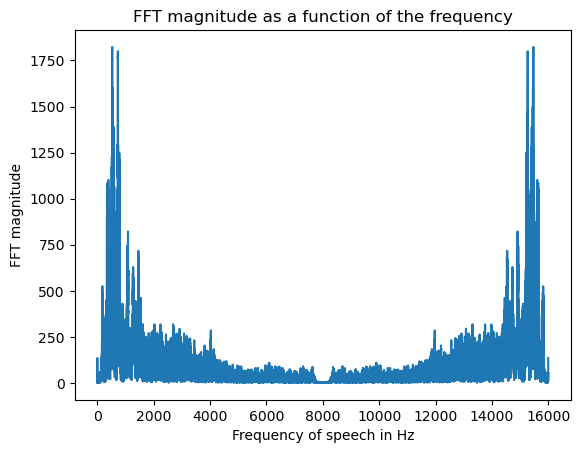

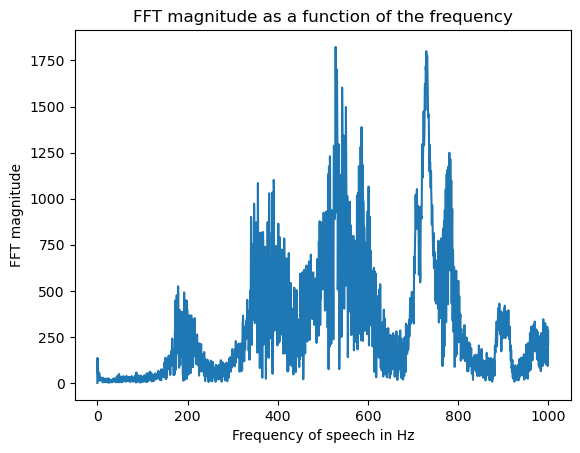

In [28]:
normalized_data = (data[0] - np.mean(data[0])) / np.std(data[0])

fft = np.fft.fft(normalized_data)
frequencies = np.linspace(0, fs, len(fft))

plt.plot(frequencies, abs(fft))
plt.xlabel("Frequency of speech in Hz")
plt.ylabel("FFT magnitude")
plt.title('FFT magnitude as a function of the frequency')
plt.show()

selected_ids = np.argwhere(frequencies < 1000)
selected_freq = frequencies[selected_ids]
selected_fft = fft[selected_ids]

plt.plot(selected_freq, abs(selected_fft))
plt.xlabel("Frequency of speech in Hz")
plt.ylabel("FFT magnitude")
plt.title('FFT magnitude as a function of the frequency')
plt.show()

There seems to be 2 different spikes, one at 500 Hz and another one at 700 Hz. Let's take the middle at 600 Hz

Samples shape: (24, 37885)
Covariance shape: (24, 24)


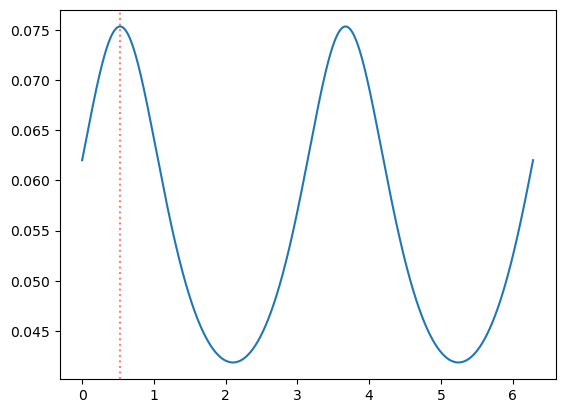

In [29]:
main_frequency = 600
spectrum = music(data, 1, mics_coords, main_frequency) 

X = np.linspace(0, 2 * np.pi, 10000)
Y = [spectrum(x) for x in X]

plt.plot(X, Y)
plt.axvline(x=angle_rad, color='red', linestyle=':', alpha=0.5)
plt.show()

In [30]:
estimated_theta = extract_frequencies(spectrum, 1, [0, np.pi / 2])[0]
print(f'estimated angle in radians = {estimated_theta:.4f}, and in degrees = {estimated_theta/np.pi*180}')
print(f'true      angle in radians = {angle_rad:.4f}, and in degrees = {angle_rad/np.pi*180}')

estimated angle in radians = 0.5284, and in degrees = 30.275999999999996
true      angle in radians = 0.5236, and in degrees = 30.0


Our implementation seems to work! Note however that the spectrum is, like it was before, not very precise (the peaks are unclear). However, this time, at least, the direction of arrival angle is much closer than our earlier result with "fake" real data.

# Results and Discussion

## Advantages

As noticed before, out initial implementation of MUSIC for DOA detected the angles of the sources well, even in the presence of noise crafted signals. It also works for real signals, so real data for the signals received by the microphone.

## Limitations

Our implementation only detects angles in $[0, \frac{\pi}{2}]$ because of the symmetry of complex exponentials, thus we always assume that the source angles are in that range, which is a strong assumption and not necessarily applicable in real life applications.

For real-valued signals, the results are not as clear: when simulating with pyroom acoustics, the detected angle for one source is not very precise. For both types or "real data", the spectra are not very clear, they look more like sinusoids than peaks at certain directions.

Finally the main issue is that MUSIC assumes a narrowband signal (which is not always the case). As above, we are constrained to choose a single frequency of interest while many other frequencies may be relevant.

# Advanced tools

For the advanced tools, we start by implementing a MUSIC for DOA estimation based on the short time Fourier transform, as described in [[2]](#stft_paper). We build on the data obtained through the simulation using pyroom acoustics.

In [31]:
seg_duration = 1.0
n_sources = 1

spectrum_stft = music_with_frequency(aroom.mic_array.signals, n_sources, fs,
                        microphone_2D_locations.T, segment_duration=1., freq_range=pra_freq_range)

Shape of sources STFT: (501, 9, 24)
STFD shape: (24, 24)
Shape of noise eigenvectors: (24, 23)


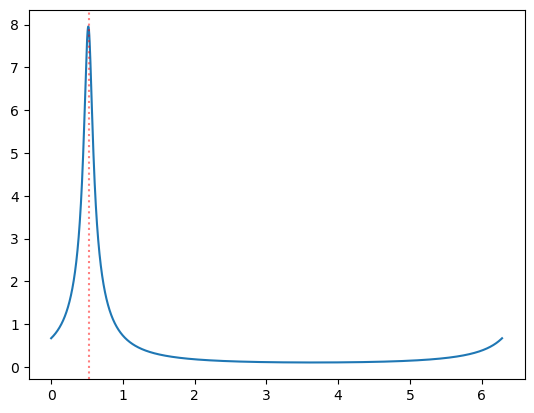

In [32]:
X = np.linspace(0, 2 * np.pi, 10000)
Y = np.array([spectrum_stft(x) for x in X])

plt.plot(X, Y)

plt.axvline(x=angle_rad, color='red', linestyle=':', alpha=0.5)

plt.show()

In [33]:
print("Extracted frequencies in degrees:", extract_frequencies(spectrum, n_sources, [0, 2 * np.pi])* 180 / np.pi)
print("Real angle in degrees:", azimuth * 180 / np.pi)

Extracted frequencies in degrees: [30.276]
Real angle in degrees: [30.]


Even though the angle is still not exact, it is closer than it was before. Clearly, this is already a big improvement! Additionally, the earlier spectrum looked like a sinusoid with two (very unclear) peaks. Here, we only see one peak. It is still not as clear as it was with crafted signals, but it is already much better than before.

# Plot for Hilbert stuff

Samples shape: (24, 37885)
Covariance shape: (24, 24)
Samples shape: (24, 37885)
Covariance shape: (24, 24)


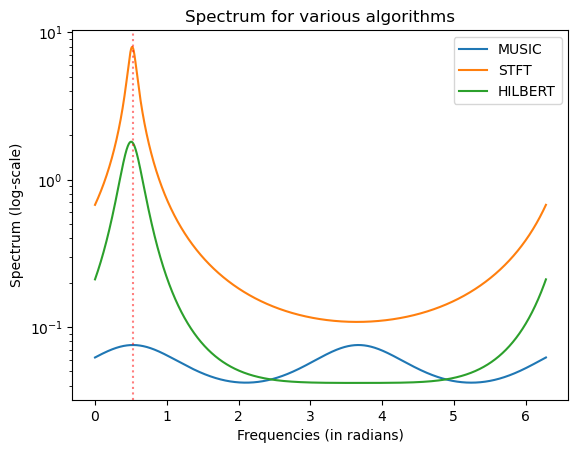

In [34]:
spectrum_bad = music(data, 1, mics_coords, main_frequency) 
spectrum_hilbert = music(hilbert(data).conj(), 1, mics_coords, main_frequency) 

X = np.linspace(0, 2 * np.pi, 10000)

plt.plot(X, [spectrum_bad(x) for x in X], label='MUSIC')
plt.plot(X, [spectrum_stft(x) for x in X], label='STFT')
plt.plot(X, [spectrum_hilbert(x) for x in X], label='HILBERT')
plt.yscale('log')
plt.xlabel('Frequencies (in radians)')
plt.ylabel('Spectrum (log-scale)')
plt.title('Spectrum for various algorithms')
plt.legend()
plt.axvline(x=azimuth, color='red', linestyle=':', alpha=0.5)
plt.show()

In [35]:
print('music  ', extract_frequencies(spectrum_bad, n_sources, [0, 2 * np.pi]))
print('stft   ', extract_frequencies(spectrum_stft, n_sources, [0, 2 * np.pi]))
print('hilbert', extract_frequencies(spectrum_hilbert, n_sources, [0, 2 * np.pi]))
print('real   ', azimuth)

music   [0.52841588]
stft    [0.51773447]
hilbert [0.50328314]
real    [0.52359878]


# Plot for neural network